# Análise de Microdados de Matrícula

Este notebook realiza análises de predição de evasão escolar usando três algoritmos:
1. **Random Forest**: Classificação supervisionada (ensemble method)
2. **K-Means**: Clustering não supervisionado
3. **Neural Network**: Deep learning com PyTorch (CUDA-accelerated)

In [1]:
from zipfile import ZipFile

# Tentar usar RAPIDS com fallback pras libs normais
try:
	import cudf as pd
except ImportError:
	import pandas as pd

from algoritmos import KMeansAnalysis, NeuralNetworkAnalysis, RandomForestAnalysis

## 1. Carregamento dos Dados

In [2]:
IS_USING_RAPIDS = 'cudf' in pd.__name__
print(f'Usando RAPIDS: {IS_USING_RAPIDS}')

Usando RAPIDS: False


In [3]:
DF_KWARGS = {'sep': ';'} if IS_USING_RAPIDS else {'encoding': 'utf8', 'on_bad_lines': 'warn', 'sep': ';'}

# Carregando todos os .csv como um dataframe só
print('Carregando dados...')
with ZipFile('Microdados_Matricula.zip', 'r') as zip_file:
	dataframes = []

	for year in [2021, 2022, 2023]:
		csv_filename = f'microdados_matriculas_{year}.csv'
		print(f'Lendo {csv_filename}...')

		with zip_file.open(csv_filename) as csv_file:
			_df = pd.read_csv(csv_file, **DF_KWARGS)
			dataframes.append(_df)

	df = pd.concat(dataframes, ignore_index=True)

print(f'\nDados carregados: {len(df)} registros')
df.head()

Carregando dados...
Lendo microdados_matriculas_2021.csv...
Lendo microdados_matriculas_2022.csv...
Lendo microdados_matriculas_2023.csv...

Dados carregados: 4717935 registros


,Ano,Carga Horaria,Carga Horaria Mínima,Categoria da Situação,Co Inst,Cod Unidade,Cor / Raça,Código da Matricula,Código da Unidade de Ensino - SISTEC,Código do Ciclo Matricula,...,Vagas Extraordinárias l9,Vagas Regulares AC,Vagas Regulares l1,Vagas Regulares l10,Vagas Regulares l13,Vagas Regulares l14,Vagas Regulares l2,Vagas Regulares l5,Vagas Regulares l6,Vagas Regulares l9
0,2021,200,200.0,Evadidos,26243,557,Amarela,96176470,3479.0,2716099,...,0.0,850.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2021,160,160.0,Em curso,26436,6002,Amarela,102483972,45430.0,2830452,...,0.0,2834.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2021,160,160.0,Em curso,26436,6002,Amarela,102459282,45430.0,2830437,...,0.0,1234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2021,40,160.0,Em curso,26419,116,Amarela,97887414,2936.0,2745532,...,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,2021,1380,1200.0,Em curso,26404,436,Amarela,91646798,2947.0,2632269,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## 2. Configuração das Colunas

In [4]:
EVAL_COLUMN = 'Categoria da Situação'  # A coluna que a gente quer prever
WANTED_COLUMNS = (
	'Ano',
	'Carga Horaria',
	'Carga Horaria Mínima',
	'Co Inst',
	'Cod Unidade',
	'Cor / Raça',
	'Código da Unidade de Ensino - SISTEC',
	'Código do Município com DV',
	'Data de Fim Previsto do Ciclo',
	'Data de Inicio do Ciclo',
	'Eixo Tecnológico',
	'Faixa Etária',
	'Fator Esforço Curso',
	'Fonte de Financiamento',
	'Idade',
	'Instituição',
	'Matrícula Atendida',
	'Modalidade de Ensino',
	'Município',
	'Nome de Curso',
	'Região',
	'Renda Familiar',
	'Sexo',
	'Subeixo Tecnológico',
	'Tipo de Curso',
	'Tipo de Oferta',
	'Total de Inscritos',
	'Turno',
	'UF',
	'Unidade de Ensino',
	'Vagas Extraordinárias AC',
	'Vagas Extraordinárias l1',
	'Vagas Extraordinárias l10',
	'Vagas Extraordinárias l13',
	'Vagas Extraordinárias l14',
	'Vagas Extraordinárias l2',
	'Vagas Extraordinárias l5',
	'Vagas Extraordinárias l6',
	'Vagas Extraordinárias l9',
	'Vagas Regulares AC',
	'Vagas Regulares l1',
	'Vagas Regulares l10',
	'Vagas Regulares l13',
	'Vagas Regulares l14',
	'Vagas Regulares l2',
	'Vagas Regulares l5',
	'Vagas Regulares l6',
	'Vagas Regulares l9',
)  # As colunas que fazem sentido ser avaliadas

print(f'Coluna alvo: {EVAL_COLUMN}')
print(f'Total de features: {len(WANTED_COLUMNS)}')

Coluna alvo: Categoria da Situação
Total de features: 48


## 3. Random Forest Analysis

Análise supervisionada usando Random Forest para predição de evasão.

🌲 RANDOM FOREST ANALYSIS - Predição de Evasão Escolar
📊 Preprocessando dados...

🔍 Distribuição das classes (antes):
Categoria da Situação
Em curso       0.361439
Evadidos       0.179843
Concluintes    0.163807
Em Curso       0.147949
Concluídos     0.146963
Name: proportion, dtype: float64

🔍 Distribuição das classes (depois):
Categoria da Situação
1    0.820157
0    0.179843
Name: proportion, dtype: float64

✅ Dados preprocessados!

📈 Calculando correlações...

🔝 Top 10 correlações:
Cod Unidade                             0.366456
Código da Unidade de Ensino - SISTEC    0.366248
Unidade de Ensino                       0.365517
Código do Município com DV              0.335940
Instituição                             0.335858
Vagas Regulares AC                      0.327602
Data de Fim Previsto do Ciclo           0.327014
Total de Inscritos                      0.315324
Data de Inicio do Ciclo                 0.313140
Carga Horaria                           0.307483
dtype: float64

🌲 Tr

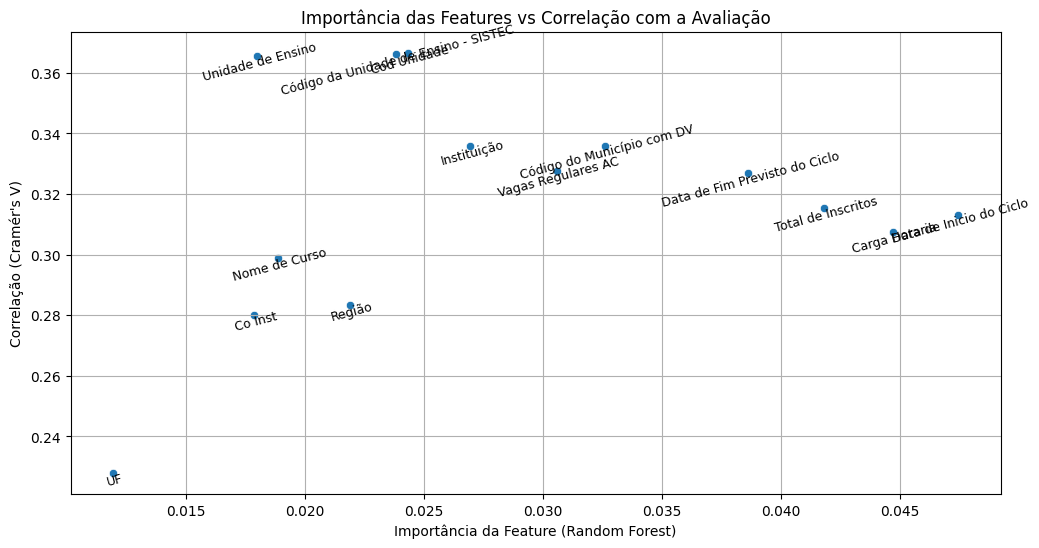


💾 Análise salva em feature_analysis.csv

✅ Análise Random Forest concluída!


In [5]:
# Criar e executar análise Random Forest
rf_analysis = RandomForestAnalysis(df, EVAL_COLUMN, WANTED_COLUMNS)
rf_analysis.run()

## 4. K-Means Clustering Analysis

Análise não supervisionada usando K-Means para identificar padrões de evasão.

K-MEANS CLUSTERING - Análise de Padrões de Evasão
Preprocessando dados...
Dados preprocessados!

Testando 8 valores de K para método do cotovelo...
Dataset grande, usando amostra de 50000 registros...
K=2: inertia=144082535956.98
K=3: inertia=108893161088.20
K=4: inertia=90481061785.65
K=5: inertia=81969635263.35
K=6: inertia=71162522633.37
K=7: inertia=64316089765.89
K=8: inertia=60310466469.48

K ótimo selecionado: 4

Gerando gráfico do método do cotovelo...


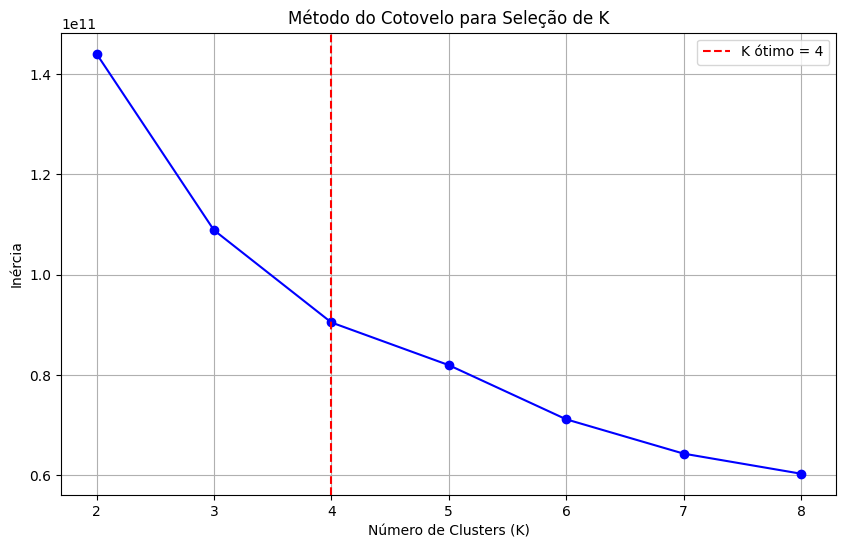


Treinando modelo K-Means com K=4...
Modelo treinado!

Analisando clusters...

Cluster 0:
Total de alunos: 960484
Taxa de evasão: 0.00%
Top 5 características:
- Ano: 2023
- Carga Horaria: 40
- Carga Horaria Mínima: 160.0
- Co Inst: 26436
- Cod Unidade: 293

Cluster 1:
Total de alunos: 1608012
Taxa de evasão: 0.00%
Top 5 características:
- Ano: 2023
- Carga Horaria: 30
- Carga Horaria Mínima: 160.0
- Co Inst: 26419
- Cod Unidade: 116

Cluster 2:
Total de alunos: 766020
Taxa de evasão: 0.00%
Top 5 características:
- Ano: 2021
- Carga Horaria: 160
- Carga Horaria Mínima: 1200.0
- Co Inst: 26436
- Cod Unidade: 6002

Cluster 3:
Total de alunos: 1383419
Taxa de evasão: 0.00%
Top 5 características:
- Ano: 2022
- Carga Horaria: 3200
- Carga Horaria Mínima: 1200.0
- Co Inst: 26439
- Cod Unidade: 583

Gerando visualização dos clusters (PCA)...


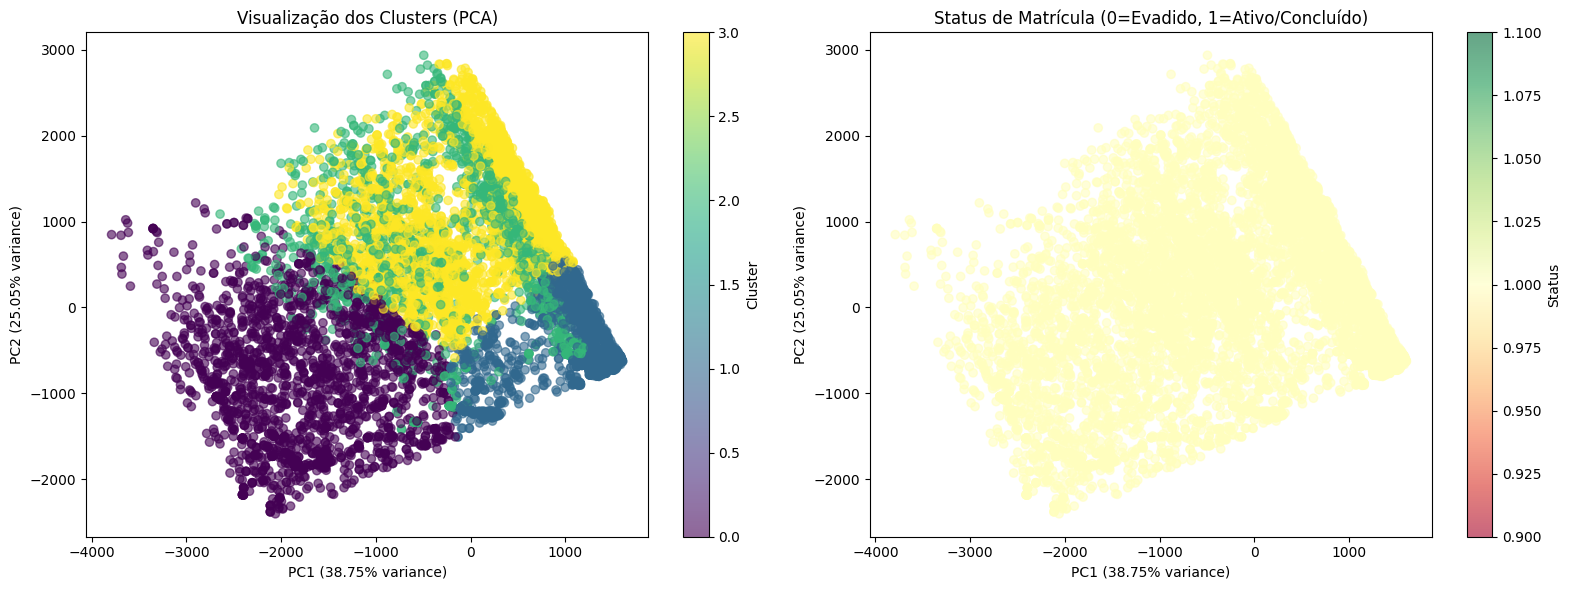


Gerando gráfico de taxas de evasão por cluster...


d:\Codes\Microdados_Matricula\algoritmos\kmeans.py:253: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


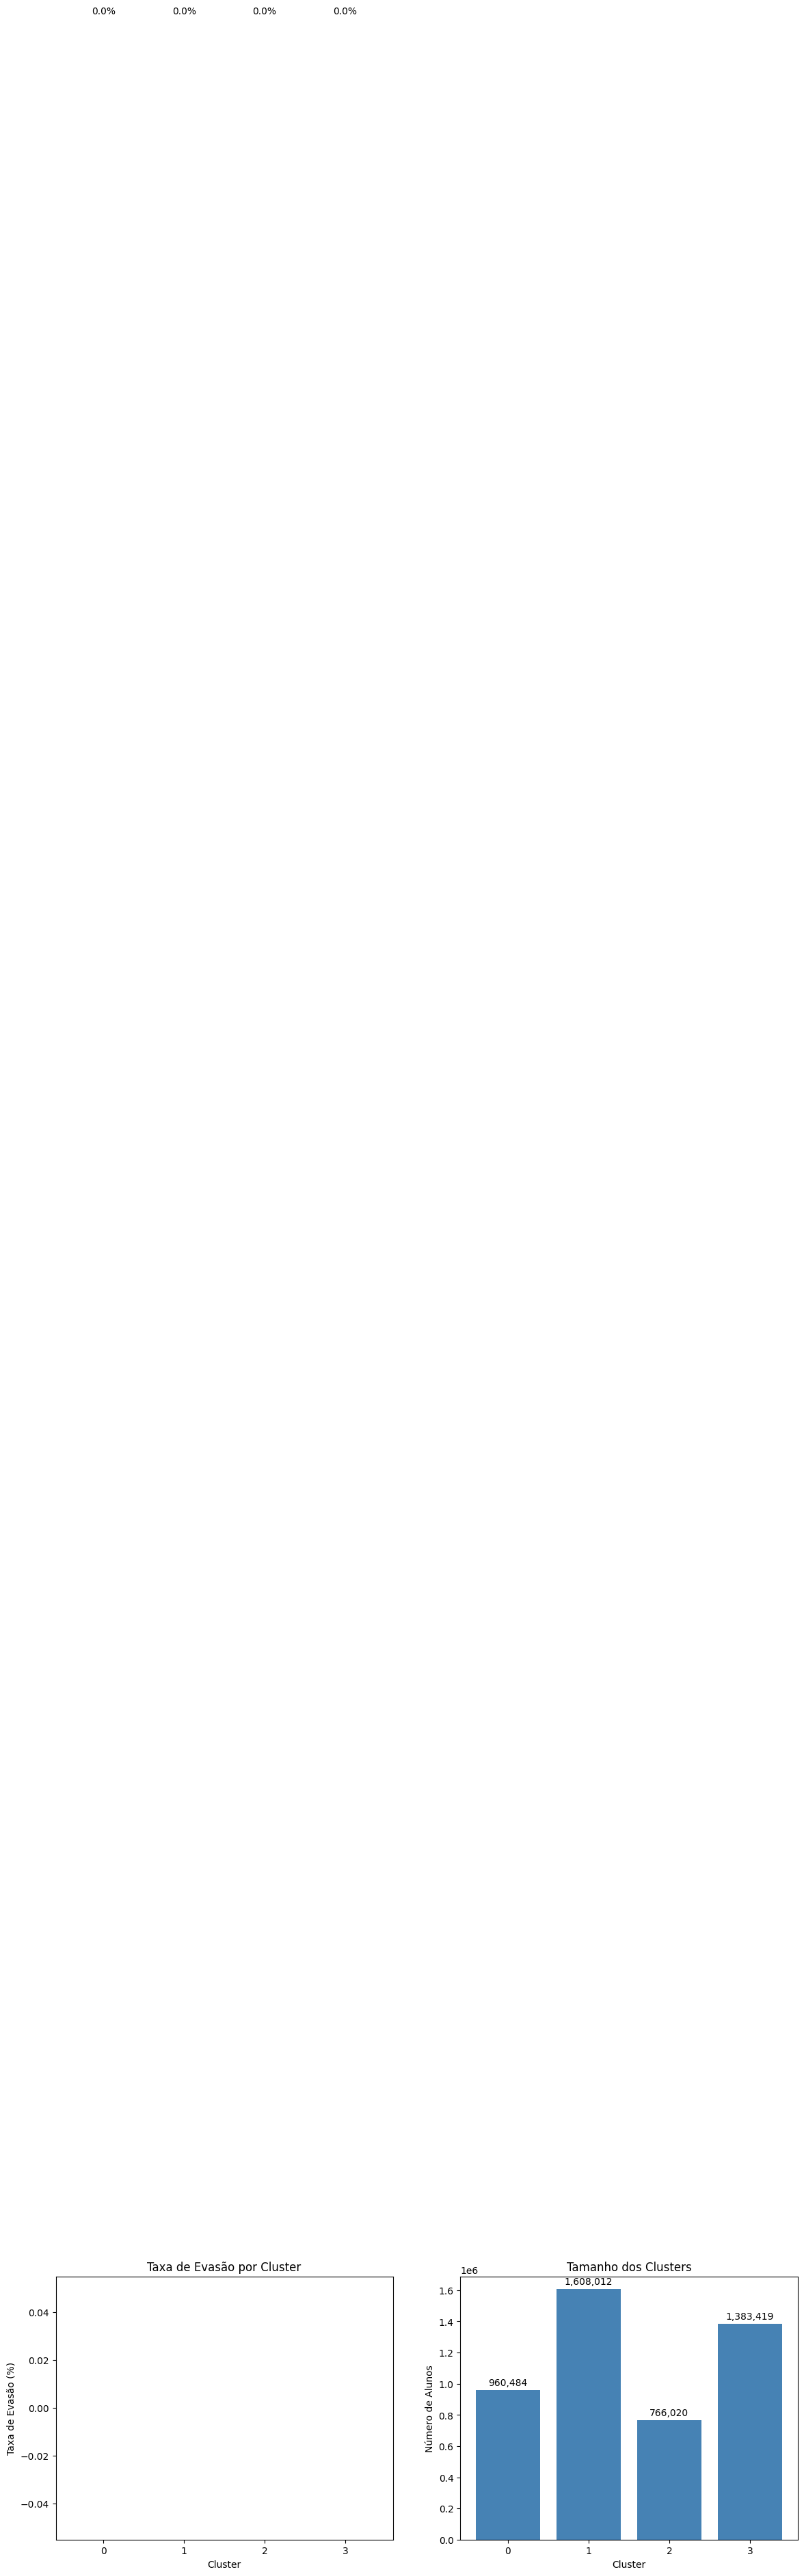


Análise salva em cluster_analysis.csv

Análise K-Means concluída!


In [6]:
# Criar e executar análise K-Means
kmeans_analysis = KMeansAnalysis(df, EVAL_COLUMN, WANTED_COLUMNS)
kmeans_analysis.run()

## 5. Neural Network Analysis

Análise supervisionada usando Deep Learning (PyTorch) com aceleração CUDA.

🧠 NEURAL NETWORK ANALYSIS - Predição de Evasão Escolar
Preprocessando dados...
Dispositivo: cpu

Distribuição das classes (antes):
Categoria da Situação
Em curso       0.361439
Evadidos       0.179843
Concluintes    0.163807
Em Curso       0.147949
Concluídos     0.146963
Name: proportion, dtype: float64

Distribuição das classes (depois):
Categoria da Situação
1    0.820157
0    0.179843
Name: proportion, dtype: float64

Dados preprocessados!

Preparando dataloaders (batch_size=1024)...
Train: 3396913 samples
Validation: 377435 samples
Test: 943587 samples
🧠 Treinando Neural Network (20 epochs)...
Epoch 1/20 - Train Loss: 0.3746, Train Acc: 0.8545 - Val Loss: 0.3521, Val Acc: 0.8611
Epoch 5/20 - Train Loss: 0.3470, Train Acc: 0.8630 - Val Loss: 0.3364, Val Acc: 0.8650
Epoch 10/20 - Train Loss: 0.3426, Train Acc: 0.8642 - Val Loss: 0.3319, Val Acc: 0.8666
Epoch 15/20 - Train Loss: 0.3405, Train Acc: 0.8647 - Val Loss: 0.3298, Val Acc: 0.8669
Epoch 20/20 - Train Loss: 0.3396, Train Acc:

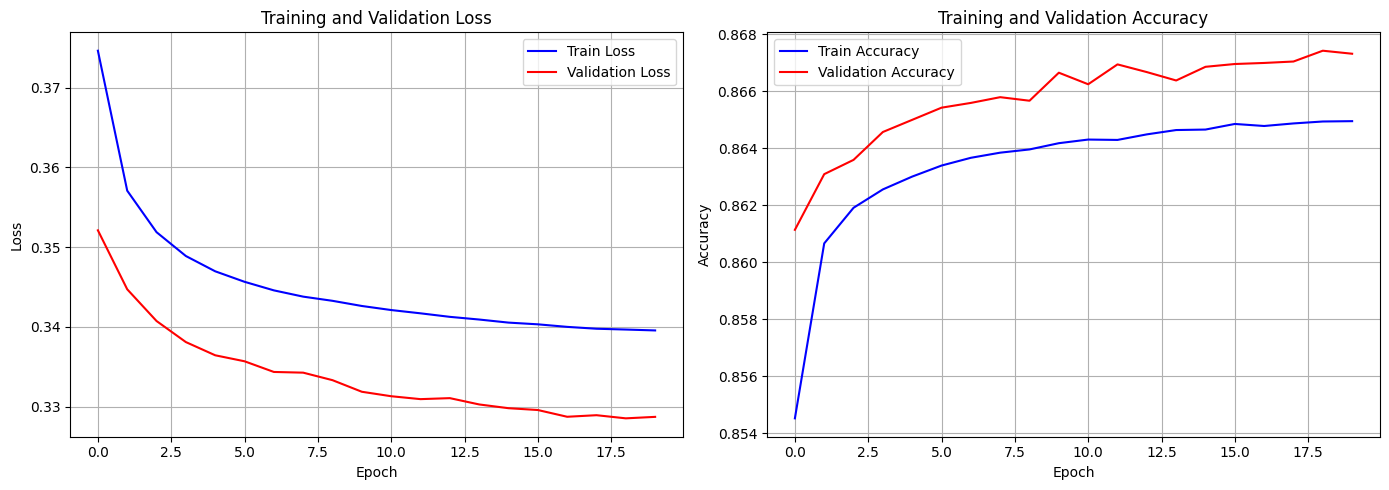


Gerando matriz de confusão...


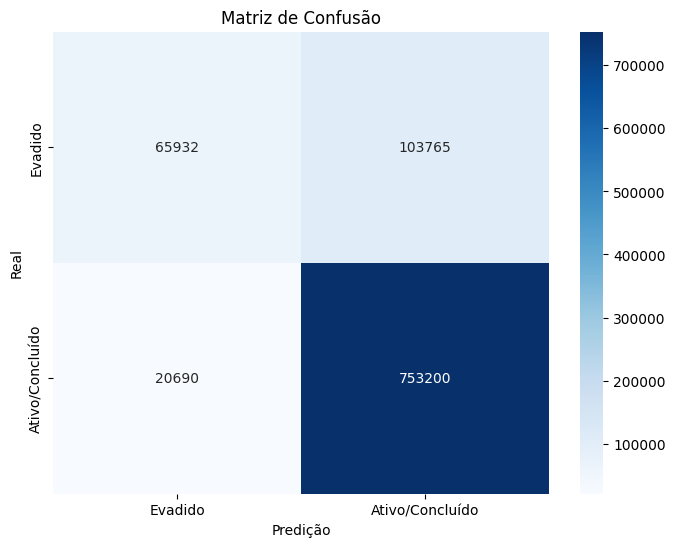


Gerando curva ROC...


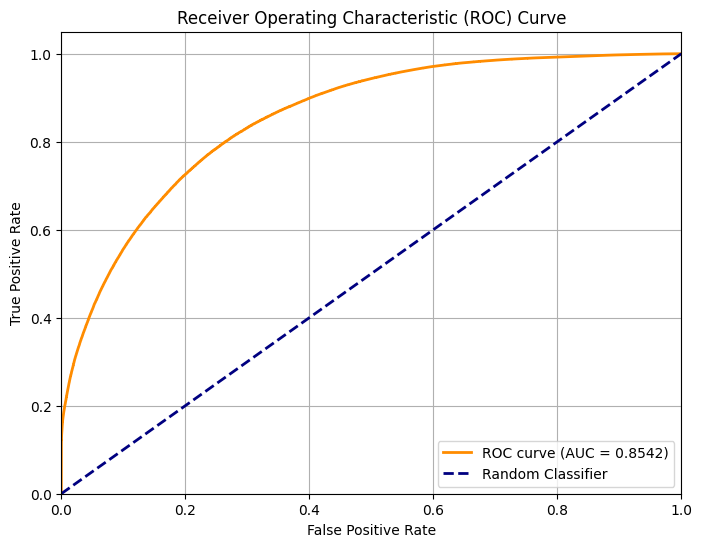


Modelo salvo em dropout_model.pth

Histórico de treinamento salvo em neural_network_analysis.csv

✅ Análise Neural Network concluída!


In [5]:
# Criar e executar análise Neural Network
# Nota: Este algoritmo usa aceleração CUDA se disponível (GPU)
nn_analysis = NeuralNetworkAnalysis(df, EVAL_COLUMN, WANTED_COLUMNS)
nn_analysis.run(epochs=20, batch_size=1024, lr=0.001)

## 6. Conclusão

Todas as três análises foram executadas com sucesso:

- **Random Forest**: Classificação supervisionada usando ensemble de árvores de decisão
  - Fornece predições de evasão e importância das features
  - Robusto contra overfitting e bom para interpretar importância de variáveis
  
- **K-Means**: Clustering não supervisionado para análise de padrões
  - Identifica grupos de estudantes com padrões similares
  - Calcula taxas de evasão por cluster
  - Útil para segmentação e identificação de perfis de risco
  
- **Neural Network**: Deep learning com PyTorch (CUDA-accelerated)
  - Modelo de redes neurais profundas com múltiplas camadas
  - Usa aceleração GPU (CUDA) quando disponível
  - Fornece predições com métricas avançadas (ROC-AUC, curva ROC)
  - Melhor capacidade de modelar relações não-lineares complexas

### Arquivos Gerados

Os resultados foram salvos em:
- `feature_analysis.csv` - Análise do Random Forest
- `cluster_analysis.csv` - Análise do K-Means
- `neural_network_analysis.csv` - Histórico de treinamento da Neural Network
- `dropout_model.pth` - Modelo Neural Network treinado (PyTorch)

### Comparação dos Algoritmos

| Algoritmo | Tipo | Interpretabilidade | Complexidade | Performance |
|-----------|------|-------------------|--------------|-------------|
| Random Forest | Supervisionado | Alta | Média | Alta |
| K-Means | Não supervisionado | Média | Baixa | Média |
| Neural Network | Supervisionado | Baixa | Alta | Muito Alta |